# 01 - Training data analysis

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Extract the information from the mat files into json. 
# taken from http://www.a2ialab.com/lib/exe/fetch.php?media=public:scripts:svhn_dataextract_tojson.py.txt

def reformat_digitstruct():
    for a in ['test', 'train']:
        cmd = str.format("python svhn_dataextract_tojson.py -f {0}/digitStruct.mat -o {0}/digitStruct", a)
        print(cmd)
        result = os.system(cmd)

In [4]:
# Load the information out of the json files
import json

def load_file_meta(folder):
    results = []
    filename = os.path.join(folder, 'digitStruct.json')
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    for file_info in data:
        pic_info = {}
        pic_info['boxes'] = [{a : int(item[a]) for a in ['top', 'left', 'height', 'width']}
                             for item in file_info['boxes']]
        pic_info['label'] = np.array([int(item['label']) % 10 for item in file_info['boxes']])
        pic_info['filename'] = os.path.join(folder, file_info['filename'])
        
        # Calculate the bounding box of the numbers
        x1 = pic_info['boxes'][0]['left']
        x2 = pic_info['boxes'][-1]['left'] + pic_info['boxes'][-1]['width']
        
        y1 = np.min([b['top'] for b in pic_info['boxes']])
        y2 = np.max([b['top'] + b['height'] for b in pic_info['boxes']])
        
        pic_info['bbox'] = [x1, y1, x2, y2]
        pic_info['bbox_x'] = [x1, x2]
        pic_info['bbox_y'] = [y1, y2]
        pic_info['bbox_width'] = x2 - x1
        pic_info['bbox_height'] = y2 - y1
        pic_info['center_x'] = (x1 + x2) // 2
        pic_info['center_y'] = (y1 + y2) // 2
        pic_info['center'] = [pic_info['center_x'], pic_info['center_y']]
        
        results.append(pic_info)
    return results

test_info = load_file_meta('test')
train_info = load_file_meta('train')

Length:33402
Max:6, min:1
Length:13068
Max:5, min:1


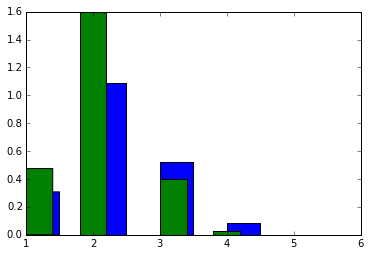

Length:33392
Max:4, min:1


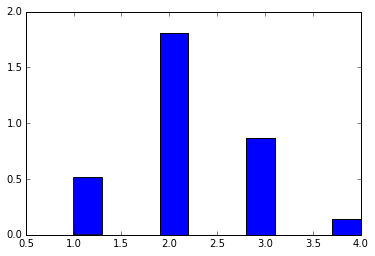

Length:33392
Max:423, min:9
Length:13068
Max:222, min:10


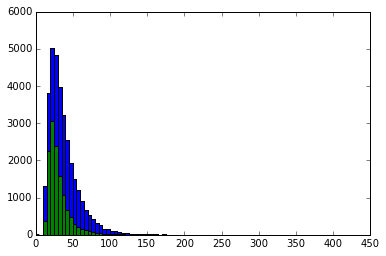

(33392, 11)
(13068, 11)
Length:20147
Max:150, min:28
Length:13068
Max:222, min:10


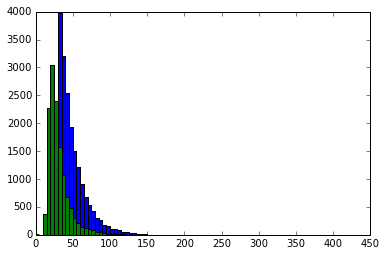

(20147, 11)
(13068, 11)


In [5]:
def show_hist2(data, show=False, **kwargs):
    print("Length:%d" % data.shape[0])
    print("Max:%d, min:%d" % (np.max(data), np.min(data)))
    plt.hist(data, **kwargs)
    if show: plt.show()

df_train = pd.DataFrame(data=train_info)
df_test = pd.DataFrame(data=test_info)

show_hist2(df_train['label'].map(len), normed=True)
show_hist2(df_test['label'].map(len), True, normed=True)

df_train = df_train[df_train['label'].map(len) <= 4]
show_hist2(df_train['label'].map(len), True, normed=True)
#df_test = pd.DataFrame(data=test_info)


bin_size = 5
data = df_train['bbox_height']
bins=np.arange(0, max(data) + bin_size, bin_size)
show_hist2(data, bins=bins)
show_hist2(df_test['bbox_height'], True, bins=bins)


#Drop extreme sizes, i.e. tiny ones
print(df_train.shape)
print(df_test.shape)
min_height, max_height = 28, 150

# Drop all that doesn't have min 28 pixels. Only in training data
df_train = df_train.loc[(df_train.bbox_height >= min_height) & (df_train.bbox_height <= max_height)]

data = df_train['bbox_height'].values
show_hist2(data, bins=bins)
show_hist2(df_test['bbox_height'], True, bins=bins)

print(df_train.shape)
print(df_test.shape)

************************************************************
('Original', (123, 216))
('Cropped', (56, 56))


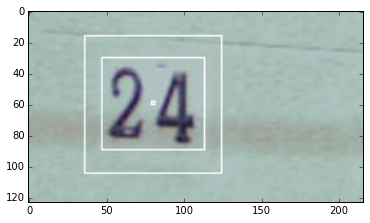

Filename:train/9356.png
Label:[2 4]
('Color range:', 0.5, -0.48230222)


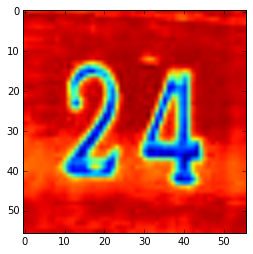

************************************************************
('Original', (31, 70))
('Cropped', (56, 56))


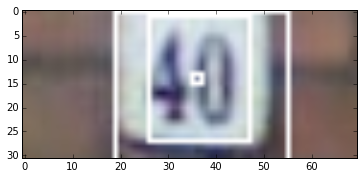

Filename:train/11147.png
Label:[4 0]
('Color range:', 0.5, -0.51176524)


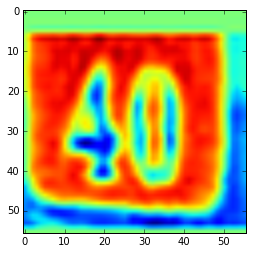

************************************************************
('Original', (166, 318))
('Cropped', (56, 56))


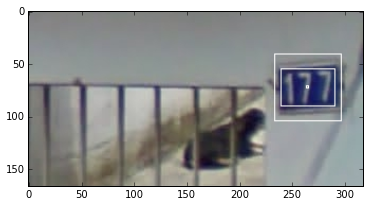

Filename:train/6000.png
Label:[1 7 7]
('Color range:', 0.5, -0.49653488)


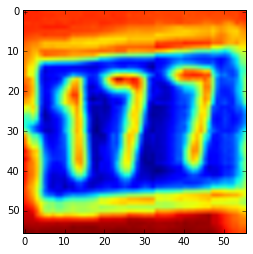

************************************************************
('Original', (40, 98))
('Cropped', (56, 56))


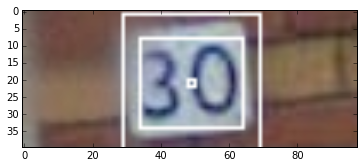

Filename:train/25851.png
Label:[3 0]
('Color range:', 0.5, -0.50544679)


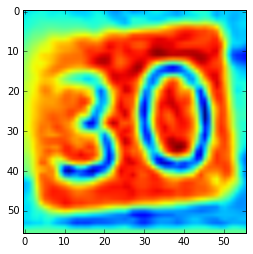

************************************************************
('Original', (24, 55))
('Cropped', (56, 56))


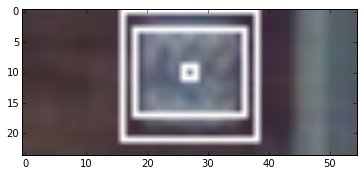

Filename:train/31413.png
Label:[4 0 9]
('Color range:', 0.5, -0.51880324)


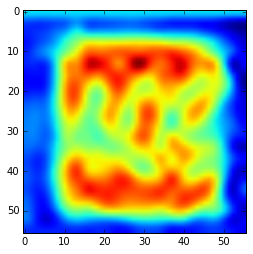

************************************************************
('Original', (15, 33))
('Cropped', (56, 56))


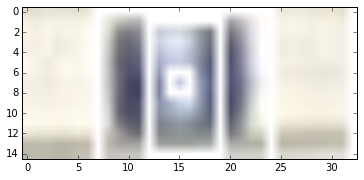

Filename:train/30780.png
Label:[5]
('Color range:', 0.5, -0.51168174)


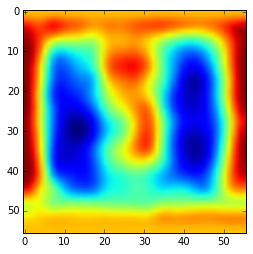

************************************************************
('Original', (104, 251))
('Cropped', (56, 56))


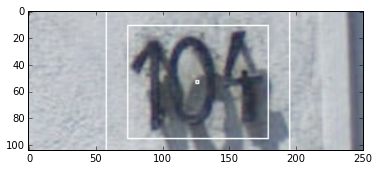

Filename:train/4324.png
Label:[1 0 4]
('Color range:', 0.5, -0.46303409)


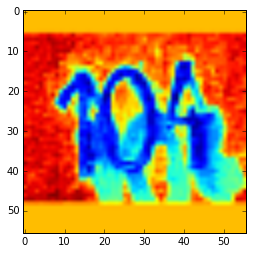

************************************************************
('Original', (27, 69))
('Cropped', (56, 56))


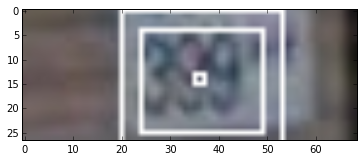

Filename:train/11123.png
Label:[3 9 9]
('Color range:', 0.5, -0.48800927)


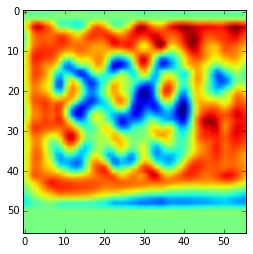

************************************************************
('Original', (55, 107))
('Cropped', (56, 56))


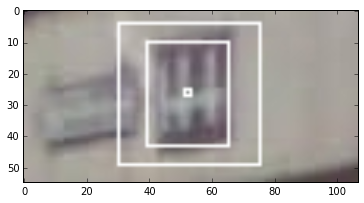

Filename:train/24994.png
Label:[1 4 4]
('Color range:', 0.5, -0.49798274)


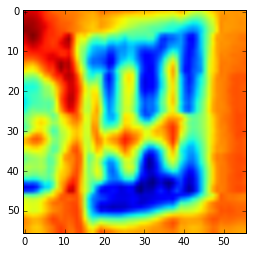

************************************************************
('Original', (60, 114))
('Cropped', (56, 56))


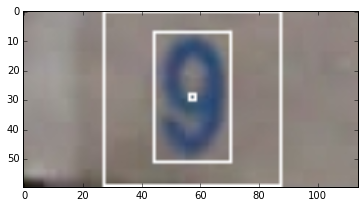

Filename:train/25805.png
Label:[9]
('Color range:', 0.5, -0.48291346)


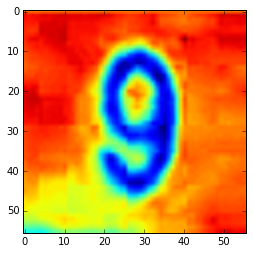

In [12]:
pixel_depth = 255.0  # Number of levels per pixel.
import os
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn

img_height = 56 # Chosen to work with the Android camera app nicely
img_width = 56
screen_ratio = 1080./1920.

def pre_process_file(pic_info, show=False):
    image_file = pic_info['filename']

    if show:
        im = Image.open(pic_info['filename'])                                        
        draw = ImageDraw.Draw(im)
        draw.rectangle(pic_info['bbox'])
        draw.rectangle([pic_info['center'][j]  + k for j, k in zip([0, 1, 0, 1], [-1, -1, 1, 1])])
        
    image_data = ndimage.imread(image_file, flatten=True).astype(float)
    
    # Calc a space around the digits as a buffer based on the y axis
    buff_size = int((pic_info['center_y'] - pic_info['bbox_y'][0]) * .4)
  
    # Create our ideal bounding box      
    x_start = pic_info['bbox_x'][0] - buff_size
    x_end = pic_info['bbox_x'][1] + buff_size
    
    y_start = pic_info['bbox_y'][0] - buff_size
    y_end = pic_info['bbox_y'][1] + buff_size
    
    dy, dx = y_end-y_start, x_end-x_start
    
    
    if dx > dy:
        y_start -= (dx - dy) // 2
        y_end = y_start + dx
    else:
        x_start -= (dy - dx) // 2
        x_end = x_start + dy
        
    dy, dx = y_end-y_start, x_end-x_start
        
    max_size = np.max([dx, dy])
    n_x_start, n_x_end = 0, dx
    n_y_start, n_y_end = 0, dy

    if x_start < 0:
        diff = 0-x_start
        n_x_start += diff
        x_start += diff        
        
    if y_start < 0:
        diff = 0-y_start
        n_y_start += diff
        y_start += diff
        
    if y_end > image_data.shape[0]:
        diff = y_end - image_data.shape[0]
        y_end -= diff
        n_y_end -= diff
                    
    if x_end > image_data.shape[1]:
        diff = x_end - image_data.shape[1]
        x_end -= diff
        n_x_end -= diff
        
    if show:
        draw.rectangle([x_start, y_start, x_end, y_end])
       
    square_output = np.ones([max_size, max_size]) * np.mean(image_data)
    
    square_output[n_y_start:n_y_end, n_x_start:n_x_end] = \
        image_data[y_start:y_end, x_start:x_end]
        
    factor = 1.0 * img_height / square_output.shape[0]
    img_zoomed = spn.interpolation.zoom(square_output, factor)
            
    img_colors = img_zoomed.astype(np.float32) - np.min(square_output)
    img_colors = img_colors / np.max(img_colors) - 0.5

    if show:
        print('*' * 60)
        print("Original", image_data.shape)
        print("Cropped", img_colors.shape)
        plt.imshow(im)
        plt.show()
        print("Filename:%s" % pic_info['filename'])
        print("Label:%s" % pic_info['label'])
        print("Color range:", np.max(img_colors), np.min(img_colors))
        plt.imshow(img_colors)
        plt.show()

    return img_colors, pic_info['label']

np.random.shuffle(train_info)
for i in range(10):
    tmp_img, tmp_label = pre_process_file(train_info[i], show=True)

In [ ]:
from multiprocessing import Pool
from functools import partial


def pre_process_img_map(args):
    return pre_process_file(**args)


def generate_batch_parallel(pic_info_list, show=False):
    """Load the data for a single letter label."""
    global started
    global finished
    started = 0
    finished = 0
    pool = Pool()    
    results = pool.map(partial(pre_process_file), pic_info_list)
    pool.close()
    pool.join()
    
    imgs, labels = zip(*results)
    return np.array(imgs), np.array(labels)
    

np.random.shuffle(train_info)
tmp_pics, tmp_labels = generate_batch_parallel(train_info[:10])

for i, tmp_label in enumerate(tmp_labels):
    print(tmp_label)
    image_data = ndimage.imread(train_info[i]['filename'])
    plt.imshow(image_data)
    plt.show()
    plt.imshow(tmp_pics[i])
    plt.show()

In [9]:
for name, info in [('train', train_info), ('test', test_info)]:
    print('Generating:%s' % name)
    pics, labels = generate_batch_parallel(info)
    
    pickle_file = 'SVHN_%s.pickle' % name
    print("Saving:%s" % pickle_file)

    try:
      f = open(pickle_file, 'wb')
      save = {
        'dataset': pics,
        'labels': labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:%dmb' % (statinfo.st_size // 1024**2))
    
print("Done")

Generating:train
Saving:SVHN_train.pickle
Compressed pickle size:535mb
Generating:test
Saving:SVHN_test.pickle
Compressed pickle size:132mb
Done
